In [1]:
import os
import torch
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tt
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset
from torchvision.utils import make_grid
import torchvision.models as models
%matplotlib inline
from copy import copy

# Data Exploration and Visualization

In [2]:
data_dir = '/kaggle/input/asl-alphabet' 
os.chdir(data_dir)
classes = os.listdir(data_dir + "/asl_alphabet_train/asl_alphabet_train")
num_classes = len(classes)

In [3]:
# Data transforms (data augmentation)
# stats = ((0.5190, 0.4992, 0.5140),(0.2038, 0.2283, 0.2356))
train_tfms = tt.Compose([tt.RandomCrop(200, padding=25, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(10),
                         tt.RandomPerspective(distortion_scale=0.2),
                         tt.ToTensor()
                        ])
test_tfms = tt.Compose([tt.ToTensor()])

In [4]:
dataset = ImageFolder(data_dir+'/asl_alphabet_train/asl_alphabet_train')

In [5]:
random_seed = 42
torch.manual_seed(random_seed);

In [6]:
val_size = int(0.15 * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(73950, 13050)

In [7]:
train_ds.dataset = copy(dataset)
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = test_tfms

In [8]:
batch_size = 50
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [9]:
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

torch.Size([3, 200, 200])
Label: C


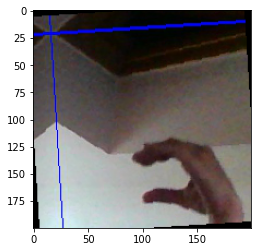

In [10]:
img, label = train_ds[0]
print(img.shape)
print('Label:', dataset.classes[label])
plt.imshow(img.permute(1,2,0))

torch.Size([3, 200, 200])
Label: E


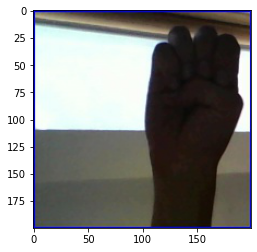

In [11]:
img, label = val_ds[0]
print(img.shape)
print('Label:', dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:49], nrow=7).permute(1, 2, 0))
        break

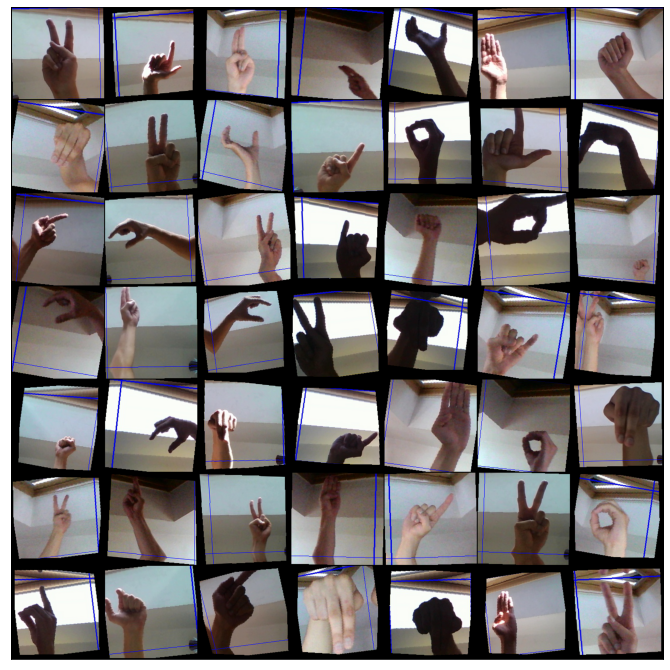

In [13]:
show_batch(train_dl)

# Picking the Training Device

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

# Creating the Model

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [19]:
num_classes

29

In [20]:
class ASLResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 29)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [21]:
model = to_device(ASLResnet(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ASLResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

# Training the Model

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.5180532932281494, 'val_acc': 0.03244274854660034}]

In [24]:
model.freeze()

In [25]:
epochs = 1
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], val_loss: 0.0020, val_acc: 0.9999
CPU times: user 1min 54s, sys: 38 s, total: 2min 32s
Wall time: 7min 23s


In [27]:
model.unfreeze()

In [28]:
%%time
history += fit_one_cycle(epochs, 1e-5, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], val_loss: 0.0010, val_acc: 1.0000
CPU times: user 1min 41s, sys: 25.5 s, total: 2min 6s
Wall time: 6min 49s


In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

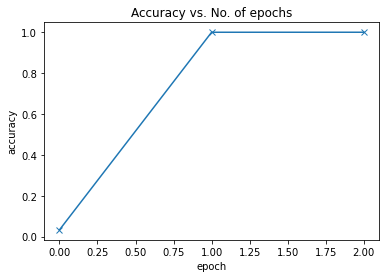

In [30]:
plot_accuracies(history)

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

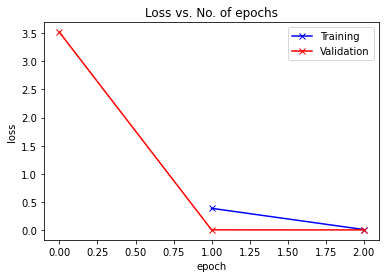

In [32]:
plot_losses(history)

In [33]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

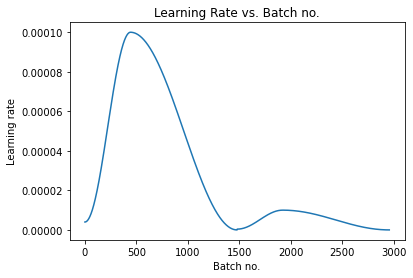

In [34]:
plot_lrs(history)

In [35]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [36]:
test_dataset = ImageFolder(data_dir+'/asl_alphabet_test')

In [37]:
len(test_dataset)

28

In [38]:
test_ds, _ = random_split(test_dataset, [28, 0])

In [39]:
test_ds.dataset.transform = tt.Compose([tt.ToTensor()])

Predicted: N


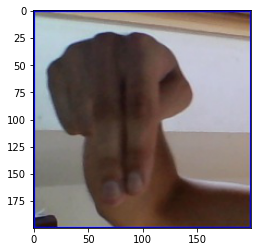

In [40]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Predicted: X


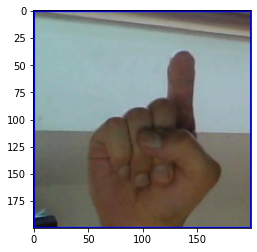

In [41]:
img, label = test_ds[1]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Predicted: I


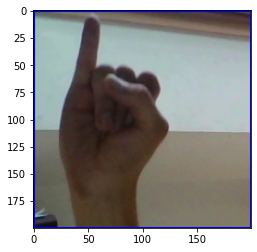

In [42]:
img, label = test_ds[16]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

In [43]:
test_dataset = ImageFolder('/kaggle/input/asl-alphabet-test-resized/asl-alphabet-test')
test_ds, _ = random_split(test_dataset, [len(test_dataset), 0])
test_ds.dataset.transform = tt.Compose([tt.ToTensor()])
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

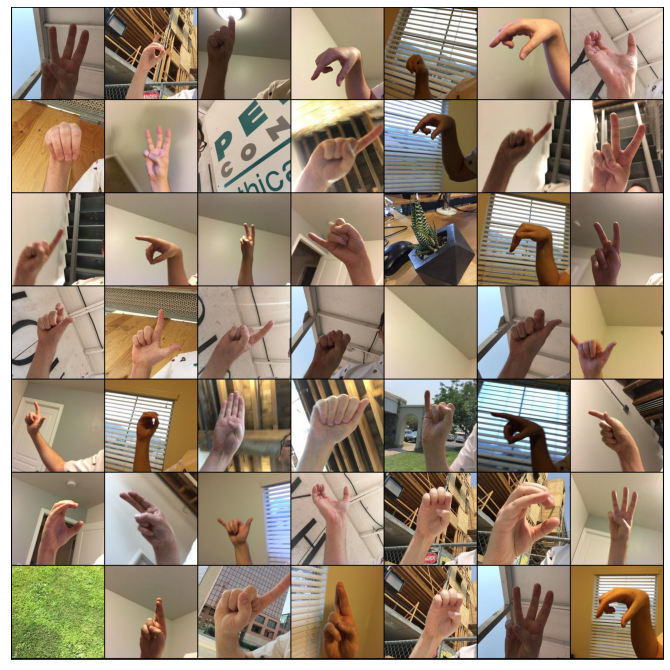

In [44]:
show_batch(test_dl)

In [45]:
test_dl = DeviceDataLoader(test_dl, device)

In [46]:
evaluate(model, test_dl)

{'val_loss': 0.9448912739753723, 'val_acc': 0.7600000500679016}

Label: V
Predicted: K


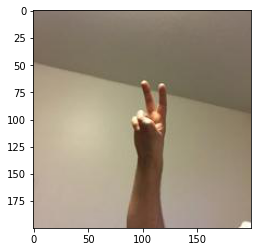

In [47]:
img, label = test_ds[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label])
print('Predicted:', predict_image(img, model))

Label: D
Predicted: O


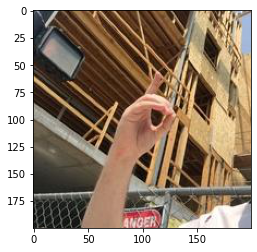

In [48]:
img, label = test_ds[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label])
print('Predicted:', predict_image(img, model))

Label: W
Predicted: W


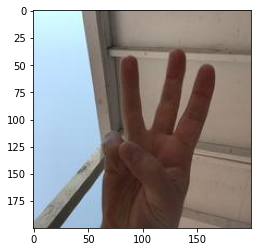

In [49]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label])
print('Predicted:', predict_image(img, model))

# Saving

In [50]:
os.chdir('/kaggle/working/')

In [51]:
torch.save(model.state_dict(), 'asl-colored-resnet34.pth')

In [52]:
!pip install jovian --upgrade --quiet

In [54]:
import jovian
jovian.reset()
jovian.log_hyperparams({
    'arch': 'Transfer ResNet34',
    'epochs': epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'max_lr': max_lr,
    'grad_clip': grad_clip,
    'weight_decay': weight_decay,
})
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   test_loss=0.9448912739753723,
                   test_acc=0.7600000500679016,
                   )

<IPython.core.display.Javascript object>

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.
[jovian] Metrics logged.


# Sanity Check

In [56]:
model2 = to_device(ASLResnet(), device)

In [57]:
model2.load_state_dict(torch.load('asl-colored-resnet34.pth'))

<All keys matched successfully>

In [58]:
evaluate(model2, valid_dl)

{'val_loss': 0.0009942724136635661, 'val_acc': 1.0}

In [59]:
evaluate(model2, test_dl)

{'val_loss': 0.9448912739753723, 'val_acc': 0.7600000500679016}

In [60]:
jovian.commit(project='project', outputs=['asl-colored-resnet34.pth'], environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/gry-galario/project


<IPython.core.display.Javascript object>